In [6]:
import numpy as np
import cv2

cv2.namedWindow('rgb')
cv2.createTrackbar('h', 'rgb', 0,255, lambda i : i)
cv2.createTrackbar('s', 'rgb', 0,255, lambda i : i)
cv2.createTrackbar('v', 'rgb', 0,255, lambda i : i)

img = np.zeros((1000,1000,3), np.uint8)

while(True):

    h = cv2.getTrackbarPos('h', 'rgb')
    s = cv2.getTrackbarPos('s', 'rgb')
    v = cv2.getTrackbarPos('v', 'rgb')

    img[:, :,0] = h
    img[:, :,1] = s
    img[:, :,2] = v

    rgb = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)

    cv2.imshow('rgb', rgb)

    key = cv2.waitKey(70)# & 0xFF

    if (key == ord('q')):
        break

cv2.destroyAllWindows()
cv2.waitKey(30)


-1

In [13]:
previous_frame  = np.zeros((540,960,3))
previous_frame.shape
previous_frame.mean()

0.0

In [12]:
import numpy as np
import cv2
import time
import json
import os

def nothing(i):
    pass

if os.path.exists('colors.json'):
    pass
else:
    data = [0,0,0,0,0,0]
    with open ('colors.json', 'w') as f:
        json.dump(data, f)


with open ('colors.json', 'r') as f:
    try:
        data = json.load(f)
    except:
        data = [0,0,0,0,0,0]

obj_coord = []
obj_time = []
left_Artem = []

cv2.namedWindow('mask1')


#cam = cv2.VideoCapture('video_2025-02-26_01-33-04.mp4')
#cam = cv2.VideoCapture('video_2025-02-27_00-07-05.mp4')
#cam = cv2.VideoCapture(0)
cam = cv2.VideoCapture('video_2025-02-27_02-27-23.mp4')

avg = np.zeros((540,960,3), np.uint8)
previous_frame  = np.zeros((540,960,3), np.uint8)
people_count = 0
shift = 0
wait_flag = False

cv2.createTrackbar('low_blue', 'mask1', data[0],255, nothing)
cv2.createTrackbar('low_green', 'mask1', data[1],255, nothing)
cv2.createTrackbar('low_red', 'mask1', data[2],255, nothing)
cv2.createTrackbar('high_blue', 'mask1', data[3],255, nothing)
cv2.createTrackbar('high_green', 'mask1', data[4],255, nothing)
cv2.createTrackbar('high_red', 'mask1', data[5],255, nothing)

start_time = time.time()

while (True):
    success, frame = cam.read()
    frame = cv2.resize(frame, (960,540))

    if (not success):
        break

    h, w, _ = frame.shape

    low_blue = cv2.getTrackbarPos('low_blue', 'mask1')
    low_green = cv2.getTrackbarPos('low_green', 'mask1')
    low_red = cv2.getTrackbarPos('low_red', 'mask1')
    high_blue = cv2.getTrackbarPos('high_blue', 'mask1')
    high_green = cv2.getTrackbarPos('high_green', 'mask1')
    high_red = cv2.getTrackbarPos('high_red', 'mask1')

    colors_info = [low_blue, low_green, low_red, high_blue,high_green,high_red]
    


    avg = cv2.addWeighted(avg, 0.94,frame, 0.06, 0)

    current_frame = cv2.absdiff(frame, avg)

    #print((cv2.absdiff(previous_frame, current_frame)).mean())
    pr_cur = cv2.absdiff(previous_frame, current_frame)
    pr_cur_mean = cv2.absdiff(previous_frame, current_frame).mean()
    #print(previous_frame.shape, current_frame.shape)
    #print(current_frame.mean())

    mask1 = cv2.inRange(current_frame, (low_blue,low_green,low_red), (high_blue,high_green,high_red))

    ksz = 7
    kernel = np.ones((ksz,ksz))
    dilate = cv2.dilate(mask1,kernel)
    eroded = cv2.dilate(dilate,kernel)

    output = cv2.connectedComponentsWithStats(eroded)
    num_comp = output[0]
    stats = output[2]

    
    for i in range(1,num_comp):
        top = stats[i, cv2.CC_STAT_TOP]
        left = stats[i, cv2.CC_STAT_LEFT]
        width = stats[i, cv2.CC_STAT_WIDTH]
        height = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]

        if (area > 15000) & (width > 150):
            cv2.rectangle(current_frame, (left, top), (left + width, top + height), (123, 231, 51), 5)
            left_Artem.append(left)

            end_time = time.time()
            obj_time.append(end_time - start_time)
            shift+=1
    
            if (len(left_Artem) >= 10):
                

                y = np.array(left_Artem[shift-10:shift])
                x = np.array(obj_time[shift-10:shift])

            
            
                slope_coeff, _ = np.polyfit(x, y, 1)
                if (slope_coeff > 140) & (wait_flag == True)  & (pr_cur_mean > 4):
                    people_count+=1
                    print(people_count)
                    wait_flag = False

                if (slope_coeff < -140) & (wait_flag == True) & (pr_cur_mean > 4):
                    people_count-=1
                    print(people_count)
                    wait_flag = False
                break
            
            ''' 
            if (left > 550) & (left < 650) & (wait_flag == True) & (pr_cur_mean > 4):
                people_count +=1
                print(people_count)
                wait_flag = False

            if (left > 700) & (wait_flag == True) & (pr_cur_mean > 4):
                people_count-=1
                print(people_count)
                wait_flag = False
            break
               ''' 

        

    if (pr_cur_mean < 0.3):
        wait_flag = True

    #print(pr_cur_mean)
    
    

    



    cv2.imshow('mask1', mask1)
        



    cv2.imshow("avg", current_frame)

    previous_frame = current_frame.copy()

    key = cv2.waitKey(30)# & 0xFF

    if (key == ord('q')):
        break

with open ('colors.json', 'w') as f:
    try:
        json.dump(colors_info, f)
    except:
        json.dump("Issue with record", f)

cam.release()
cv2.destroyAllWindows()
cv2.waitKey(30)

-1
0
1
0


-1

In [104]:
shiftt = 20
left_Artem[shiftt: shiftt+10]

[0, 0, 394, 455, 482, 878, 860, 840, 820, 868]

In [78]:
num_list = list(range(1, len(left_Artem) + 1))
len(num_list)

26

<Axes: >

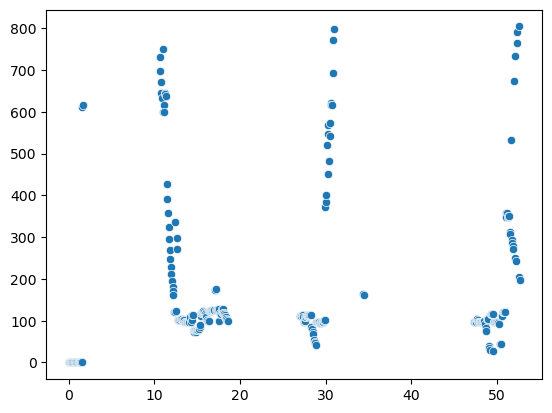

In [7]:
import seaborn as sns
num_list = list(range(1, len(left_Artem) + 1))
sns.scatterplot(x=obj_time,
                y=left_Artem)

In [5]:
obj_time[3]

0.22580599784851074

In [7]:
round(obj_time[3], 4)

0.2258